## Analysis on the raw data


In [ ]:
import os

import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt



from fault_management_uds.data.load_data import import_danova, import_ifix, import_system2000

from fault_management_uds.config import PROJ_ROOT
from fault_management_uds.config import DATA_DIR, RAW_DATA_DIR, INTERIM_DATA_DIR, PROCESSED_DATA_DIR, EXTERNAL_DATA_DIR
from fault_management_uds.config import MODELS_DIR, REPORTS_DIR, FIGURES_DIR

In [2]:
sensor_data_path = RAW_DATA_DIR / 'Bellinge' / 'sensor-data'
raw_data_path = sensor_data_path / '2_raw_data'
scripts_path = RAW_DATA_DIR / 'Bellinge' / 'scripts'

In [3]:
# Loading metadata
def import_metadata(scripts_path):
    """Load metadata, ie. the on sensors and manual removals."""

    metadata = pd.read_csv(scripts_path / '#9_Scripts' / 'etc' / 'obs_input.csv', sep=";")
    manual_remove = pd.read_csv(scripts_path / '#9_Scripts' / 'etc' / 'manual_remove.csv', sep=";")

    return metadata, manual_remove


metadata, manual_remove = import_metadata(scripts_path)
print(metadata.columns)
metadata.shape

Index(['IdMeasurement', 'Area', 'Source', 'Version', 'Type', 'Folderpath',
       'Filename', 'TagSRO', 'Navn', 'StartTime', 'EndTime', 'Conversion',
       'comment', 'unit', 'obvious_min', 'obvious_max', 'zeropoint',
       'window_frozen', 'outlier_threshold', 'outlier_width'],
      dtype='object')


(36, 20)

In [4]:
check_unique = ['IdMeasurement', 'Area', 'Source', 'Type', 'Conversion']
for col in check_unique:
    print(f"{col}: {metadata[col].unique()}")

IdMeasurement: ['G71F04R_Level1' 'G71F04R_Level2' 'G71F05R_LevelBasin'
 'G71F05R_LevelInlet' 'G71F05R_position' 'G71F06R_LevelInlet'
 'G71F68Y_LevelPS' 'G71F68Yp1' 'G71F68Yp1_power' 'G71F68Yp2_power'
 'G73F010' 'G80F11B_Level1' 'G80F11B_Level2' 'G80F13P_LevelPS'
 'G80F13Pp1_power' 'G80F13Pp2_power' 'G80F66Y_Level1' 'G80F66Y_Level2'
 'G72F040']
Area: ['Bellinge']
Source: ['iFix' 'System2000' 'Danova']
Type: ['Level' 'Position' 'Discharge' 'Power']
Conversion: [1.00000000e+00 6.89655172e-01 6.89655172e+01 3.60000000e+03
 1.00000000e+02]


In [5]:
# extract measurements
metadata['IdMeasurement'].value_counts()

IdMeasurement
G71F04R_Level1        4
G71F04R_Level2        4
G71F68Yp1             2
G80F13Pp2_power       2
G80F13Pp1_power       2
G80F13P_LevelPS       2
G71F68Yp1_power       2
G71F68Yp2_power       2
G71F68Y_LevelPS       2
G71F06R_LevelInlet    2
G71F05R_position      2
G71F05R_LevelInlet    2
G71F05R_LevelBasin    2
G73F010               1
G80F11B_Level1        1
G80F11B_Level2        1
G80F66Y_Level1        1
G80F66Y_Level2        1
G72F040               1
Name: count, dtype: int64

In [6]:
sort_cols = ['IdMeasurement', 'Source', 'StartTime']
# apply the sort
metadata = metadata.sort_values(by=sort_cols)
metadata.head(5)

,IdMeasurement,Area,Source,Version,Type,Folderpath,Filename,TagSRO,Navn,StartTime,EndTime,Conversion,comment,unit,obvious_min,obvious_max,zeropoint,window_frozen,outlier_threshold,outlier_width
31,G71F04R_Level1,Bellinge,System2000,p1,Level,./2_raw_data/,data-pG71F04R-D1-W1-BL3_M2-PV-SMO.txt,G71F04R-D1-W1-BL3_M2-PV-SMO,Niv. Indløb 1,01-08-2010,06-01-2020,100.000000,cm -> m,cm,0.001,1.5,17.09,20,0.2,1
4,G71F04R_Level1,Bellinge,System2000,p2,Level,./2_raw_data/,data-pG71F04R-D1-W1-BL3_M2-PV-SMO_red.txt,G71F04R-D1-W1-BL3_M2-PV-SMO,Niv. Indløb 1,06-01-2020,12-10-2020,68.965517,cm -> m + scaling factor wrong initially (2.9/2),cm,0.001,1.5,17.09,20,0.2,1
2,G71F04R_Level1,Bellinge,iFix,p3,Level,./2_raw_data/,SVTP03.G71F04R-D1-W1-BL3!M5-PV-SMO.F_CV_red.rpt,SVTP03.G71F04R-D1-W1-BL3!M5-PV-SMO.F_CV,Niv. Indløb 1,12-10-2020,19-11-2020,0.689655,scaling factor wrong initially,cm,0.001,1.5,17.09,20,0.2,1
0,G71F04R_Level1,Bellinge,iFix,p4,Level,./2_raw_data/,SVTP03.G71F04R-D1-W1-BL3!M5-PV-SMO.F_CV.rpt,SVTP03.G71F04R-D1-W1-BL3!M5-PV-SMO.F_CV,Niv. Indløb 1,19-11-2020,19-08-2021,1.000000,NaN,m,0.001,1.5,17.09,20,0.2,1
32,G71F04R_Level2,Bellinge,System2000,p1,Level,./2_raw_data/,data-pG71F04R-D1-W1-BL4_M2-PV-SMO.txt,G71F04R-D1-W1-BL4_M2-PV-SMO,Niv. Indløb 2,01-08-2010,06-01-2020,100.000000,cm -> m,cm,0.001,1.5,17.05,20,0.2,1


In [7]:
metadata

,IdMeasurement,Area,Source,Version,Type,Folderpath,Filename,TagSRO,Navn,StartTime,EndTime,Conversion,comment,unit,obvious_min,obvious_max,zeropoint,window_frozen,outlier_threshold,outlier_width
31,G71F04R_Level1,Bellinge,System2000,p1,Level,./2_raw_data/,data-pG71F04R-D1-W1-BL3_M2-PV-SMO.txt,G71F04R-D1-W1-BL3_M2-PV-SMO,Niv. Indløb 1,01-08-2010,06-01-2020,100.000000,cm -> m,cm,0.001,1.5,17.090,20,0.2,1
4,G71F04R_Level1,Bellinge,System2000,p2,Level,./2_raw_data/,data-pG71F04R-D1-W1-BL3_M2-PV-SMO_red.txt,G71F04R-D1-W1-BL3_M2-PV-SMO,Niv. Indløb 1,06-01-2020,12-10-2020,68.965517,cm -> m + scaling factor wrong initially (2.9/2),cm,0.001,1.5,17.090,20,0.2,1
2,G71F04R_Level1,Bellinge,iFix,p3,Level,./2_raw_data/,SVTP03.G71F04R-D1-W1-BL3!M5-PV-SMO.F_CV_red.rpt,SVTP03.G71F04R-D1-W1-BL3!M5-PV-SMO.F_CV,Niv. Indløb 1,12-10-2020,19-11-2020,0.689655,scaling factor wrong initially,cm,0.001,1.5,17.090,20,0.2,1
0,G71F04R_Level1,Bellinge,iFix,p4,Level,./2_raw_data/,SVTP03.G71F04R-D1-W1-BL3!M5-PV-SMO.F_CV.rpt,SVTP03.G71F04R-D1-W1-BL3!M5-PV-SMO.F_CV,Niv. Indløb 1,19-11-2020,19-08-2021,1.000000,NaN,m,0.001,1.5,17.090,20,0.2,1
32,G71F04R_Level2,Bellinge,System2000,p1,Level,./2_raw_data/,data-pG71F04R-D1-W1-BL4_M2-PV-SMO.txt,G71F04R-D1-W1-BL4_M2-PV-SMO,Niv. Indløb 2,01-08-2010,06-01-2020,100.000000,cm -> m,cm,0.001,1.5,17.050,20,0.2,1
5,G71F04R_Level2,Bellinge,System2000,p2,Level,./2_raw_data/,data-pG71F04R-D1-W1-BL4_M2-PV-SMO_red.txt,G71F04R-D1-W1-BL4_M2-PV-SMO,Niv. Indløb 2,06-01-2020,12-10-2020,68.965517,cm -> m + scaling factor wrong initially,cm,0.001,1.5,17.090,20,0.2,1
3,G71F04R_Level2,Bellinge,iFix,p3,Level,./2_raw_data/,SVTP03.G71F04R-D1-W1-BL4!M5-PV-SMO.F_CV_red.rpt,SVTP03.G71F04R-D1-W1-BL4!M5-PV-SMO.F_CV,Niv. Indløb 2,12-10-2020,19-11-2020,0.689655,scaling factor wrong initially,cm,0.001,1.5,17.050,20,0.2,1
1,G71F04R_Level2,Bellinge,iFix,p4,Level,./2_raw_data/,SVTP03.G71F04R-D1-W1-BL4!M5-PV-SMO.F_CV.rpt,SVTP03.G71F04R-D1-W1-BL4!M5-PV-SMO.F_CV,Niv. Indløb 2,19-11-2020,19-08-2021,1.000000,NaN,m,0.001,1.5,17.050,20,0.2,1
22,G71F05R_LevelBasin,Bellinge,System2000,p1,Level,./2_raw_data/,data-pG71F05R-D1-W1-BL3_M2-PV-SMO.txt,G71F05R-D1-W1-BL3_M2-PV-SMO,Niv. Skyllevandsbeh.,01-08-2010,12-10-2020,100.000000,cm -> m,cm,0.000,5.0,14.140,20,0.2,1
6,G71F05R_LevelBasin,Bellinge,iFix,p1,Level,./2_raw_data/,SVTP03.G71F05R-D1-W1-BL3!M5-PV-SMO.F_CV.rpt,SVTP03.G71F05R-D1-W1-BL3!M5-PV-SMO.F_CV,Niv. Skyllevandsbeh.,13-10-2020,19-08-2021,1.000000,NaN,cm,0.000,5.0,14.140,20,0.2,1


We see that even though there are multiple idMeasurements of the same name, 

the reason is, that they are at different periods and systems.

However, the _red extension remains a mystery

Understanding the sensors: check the bellinge article, Figure 4 and Table 1

## Loading the data

The goal is to load the data into a dictionary with:
- idMeasurement: dataframe with columns raw value, datetime, source

In [8]:
metadata.head(2)

,IdMeasurement,Area,Source,Version,Type,Folderpath,Filename,TagSRO,Navn,StartTime,EndTime,Conversion,comment,unit,obvious_min,obvious_max,zeropoint,window_frozen,outlier_threshold,outlier_width
31,G71F04R_Level1,Bellinge,System2000,p1,Level,./2_raw_data/,data-pG71F04R-D1-W1-BL3_M2-PV-SMO.txt,G71F04R-D1-W1-BL3_M2-PV-SMO,Niv. Indløb 1,01-08-2010,06-01-2020,100.000000,cm -> m,cm,0.001,1.5,17.09,20,0.2,1
4,G71F04R_Level1,Bellinge,System2000,p2,Level,./2_raw_data/,data-pG71F04R-D1-W1-BL3_M2-PV-SMO_red.txt,G71F04R-D1-W1-BL3_M2-PV-SMO,Niv. Indløb 1,06-01-2020,12-10-2020,68.965517,cm -> m + scaling factor wrong initially (2.9/2),cm,0.001,1.5,17.09,20,0.2,1


In [9]:

def load_raw_data_file(path, source, conversion):
    if source == 'System2000':
        raw_data = import_system2000(path, conversion)
    elif source == 'iFix':  
        raw_data = import_ifix(path, conversion)
    elif source == 'Danova':  
        raw_data = import_danova(path, conversion)
    else: 
        print("Unknown source, i.e. not System2000, iFix or Danova")
    return raw_data


def load_raw_data(metadata, sensor_data_path, save_path):
    """Load raw data files based on metadata."""

    raw_data_paths = {}

    # iterate each sensor group
    n_groups = metadata['IdMeasurement'].nunique()
    i_group = 0
    for sensor_name, sensor_group in metadata.groupby('IdMeasurement'):
        print(f"({i_group+1}/{n_groups}) Loading {sensor_name}")
        # create a dictionary with the sensor id as key and the data as value
        raw_sensor_data = pd.DataFrame()
        # iterate each row in the sensor group
        sensor_group = sensor_group.reset_index(drop=True)
        for i, row in sensor_group.iterrows():
            print(f"    {i+1}/{sensor_group.shape[0]}")
            # get the file path
            file_path = sensor_data_path / row['Folderpath'] / row['Filename']
            # load the raw data file: currently only adjust the datetime column
            sensor_data = load_raw_data_file(file_path, row['Source'], row['Conversion'])
            # sort by time
            sensor_data = sensor_data.sort_values(by='time')
            # add the raw data to the df in the dictionary
            raw_sensor_data = pd.concat([raw_sensor_data, sensor_data])
        # remove duplicated time
        raw_sensor_data = raw_sensor_data.drop_duplicates(subset=['time'])
        # sort by time
        raw_sensor_data = raw_sensor_data.sort_values(by='time')
        # remove nan values
        raw_sensor_data = raw_sensor_data.dropna(subset=['value'])
        # save the raw data as a pickle file
        file_path = save_path / f'{sensor_name}.pkl'
        raw_sensor_data.to_pickle(file_path)
        raw_data_paths[sensor_name] = file_path
        i_group += 1
        print(f"Saved {sensor_name} to {save_path / f'{sensor_name}.pkl'}")
        print('')
    # save the raw data paths
    with open(save_path / 'raw_data_paths.pkl', 'wb') as f:
        pickle.dump(raw_data_paths, f)
    return raw_data_paths


RUNTIME: 20 minutes

GOAL: saving av pickle for faster load time

In [11]:
save_path = RAW_DATA_DIR / 'Bellinge' / 'fast' / 'raw_data'

In [10]:
# create the save path if it does not exist
save_path.mkdir(parents=True, exist_ok=True)

In [12]:
# RUNTIME: 20 minutes
save_path = RAW_DATA_DIR / 'Bellinge' / 'fast' / 'raw_data'
raw_data_paths = load_raw_data(metadata, sensor_data_path, save_path)

(1/19) Loading G71F04R_Level1
    1/4
    2/4
    3/4


KeyboardInterrupt: 

In [13]:
# load the raw data paths
with open(save_path / 'raw_data_paths.pkl', 'rb') as f:
    raw_data_paths = pickle.load(f)

### TODO: manual removal data points?

In [53]:
# TODO:

In [14]:
sensor = "G71F04R_Level1"
raw_data = pd.read_pickle(raw_data_paths[sensor])
raw_data.head(5)

,time,value,quality_ifix
0,2010-05-26 21:03:03,0.0,NaN
1,2010-05-26 21:04:03,0.0,NaN
2,2010-05-26 21:05:03,0.0,NaN
3,2010-05-26 21:06:12,0.0,NaN
4,2010-05-26 21:07:03,0.0,NaN


# TODO: my own preprocessing

### Loading a subset

Based on the figure in the Bellinge article, we have the most sensor data from 2020 to 2021 and out

In [15]:
sensor_names = list(raw_data_paths.keys())

In [27]:
def create_subset_data(raw_data_paths, min_time, max_time, resample_freq):
    """Goal: Create a subset of the raw data based on time and within a single dataframe."""
    sensor_names = list(raw_data_paths.keys())
    # create an dataframe with the time as index
    time_range = pd.date_range(start=min_time, end=max_time, freq=resample_freq)
    subset_data = pd.DataFrame(index=time_range)
    for i, sensor_name in enumerate(sensor_names):
        print(f"({i+1}/{len(sensor_names)}) Loading {sensor_name}")
        raw_data = pd.read_pickle(raw_data_paths[sensor_name])
        # make sure time is of the correct type
        raw_data['time'] = pd.to_datetime(raw_data['time'])
        # set time as index
        raw_data = raw_data.set_index('time')
        # extract the value column
        raw_data = raw_data[['value']]
        # rename the value column to the sensor name
        raw_data = raw_data.rename(columns={'value': sensor_name})

        ### Performing necessary data cleaning (1 minute resampling)   
        # Create a new DataFrame with the time range and no data
        time_range = pd.date_range(start=raw_data.index.min(), end=raw_data.index.max(), freq='1min')
        time_df = pd.DataFrame(index=time_range)
        # Concatenate the original raw_data with the new time_df
        expanded_data = pd.concat([raw_data, time_df], axis=1) # This will create NaNs for the new time points, which appear after the original data
        # Handle duplicate indices (i.e., original data points that already exist in the 1-minute intervals)

        # Drop any duplicate indices (i.e., original data points that already exist in the 1-minute intervals)
        expanded_data = expanded_data[~expanded_data.index.duplicated(keep='first')]
        # Sort the data by time
        expanded_data = expanded_data.sort_index()
        # Interpolate to fill in the gaps, limiting interpolation to small gaps (e.g., up to 2 missing minutes)
        interpolated_data = expanded_data.interpolate(method='time', limit=2)
        # Now remove the original irregular time points, keeping only the regular 1-minute intervals
        regular_data = interpolated_data.loc[time_range]

        # add the data to the subset data based on time
        subset_data = pd.concat([subset_data, regular_data], axis=1)

    # sort by time
    subset_data = subset_data.sort_index()
    # save the subset data as a pickle file
    subset_data_path = save_path / 'subset_data.pkl'
    subset_data.to_pickle(subset_data_path)
    return subset_data_path


In [28]:
# create a subset of the data
min_time = '2020-01-01 00:00:00'
max_time = '2020-12-31 23:59:59'
# resample seems to be 1 minute
resample_freq = '1min'
# RUNTIME: 2 minutes
# MEMORY: ~80 MB
subset_data_path = create_subset_data(raw_data_paths, min_time, max_time, resample_freq)

(1/19) Loading G71F04R_Level1
(2/19) Loading G71F04R_Level2
(3/19) Loading G71F05R_LevelBasin
(4/19) Loading G71F05R_LevelInlet
(5/19) Loading G71F05R_position
(6/19) Loading G71F06R_LevelInlet
(7/19) Loading G71F68Y_LevelPS
(8/19) Loading G71F68Yp1
(9/19) Loading G71F68Yp1_power
(10/19) Loading G71F68Yp2_power
(11/19) Loading G72F040
(12/19) Loading G73F010
(13/19) Loading G80F11B_Level1
(14/19) Loading G80F11B_Level2
(15/19) Loading G80F13P_LevelPS
(16/19) Loading G80F13Pp1_power
(17/19) Loading G80F13Pp2_power
(18/19) Loading G80F66Y_Level1
(19/19) Loading G80F66Y_Level2


In [29]:
# load the subset data
subset_data_path = save_path / 'subset_data.pkl'
data = pd.read_pickle(subset_data_path)
print(data.shape)

(527040, 36)


In [30]:
data.head(2)

,G71F04R_Level1,quality_ifix,G71F04R_Level2,quality_ifix,G71F05R_LevelBasin,quality_ifix,G71F05R_LevelInlet,quality_ifix,G71F05R_position,quality_ifix,...,G80F13P_LevelPS,quality_ifix,G80F13Pp1_power,quality_ifix,G80F13Pp2_power,quality_ifix,G80F66Y_Level1,quality_ifix,G80F66Y_Level2,quality_ifix
2020-01-01 00:00:00,0.111490,0.0,0.127190,0.0,0.0,0.0,0.282298,0.0,0.592920,0.0,...,1.049,100.0,0.0,100.0,16.9768,100.0,0.051706,100.0,0.05115,100.0
2020-01-01 00:01:00,0.112483,0.0,0.127107,0.0,0.0,0.0,0.282986,0.0,0.592703,0.0,...,0.807,100.0,0.0,100.0,16.9360,100.0,0.047824,100.0,0.05160,100.0


In [72]:
# are the any with only nan values
nan_sensors = data.columns[data.isna().all()]
print(f"Columns with only nan values: {nan_sensors}")

Columns with only nan values: Index([], dtype='object')


Conversion converts everything to meters?

In [64]:
# creating a new subset metadata
# columns: IdMeasurement, Type, Navn, Conversion, Unit, Obvious_min, Obvious_max, Zeropoint
print(metadata.shape)
subset_metadata = metadata[['IdMeasurement', 'Type', 'Navn', 'unit', 'obvious_min', 'obvious_max', 'zeropoint']].copy()
# rename unit cm to m
subset_metadata['unit'] = subset_metadata['unit'].replace('cm', 'm') # based on the conversion

# set all columns to lower case
subset_metadata.columns = subset_metadata.columns.str.lower()

# drop duplicated id measurements
subset_metadata = subset_metadata.drop_duplicates(subset='idmeasurement')

print(subset_metadata.shape)
subset_metadata.head(2)

(36, 20)
(19, 7)


,idmeasurement,type,navn,unit,obvious_min,obvious_max,zeropoint
31,G71F04R_Level1,Level,Niv. Indløb 1,m,0.001,1.5,17.09
32,G71F04R_Level2,Level,Niv. Indløb 2,m,0.001,1.5,17.05


In [81]:
print(subset_metadata['idmeasurement'].unique())

['G71F04R_Level1' 'G71F04R_Level2' 'G71F05R_LevelBasin'
 'G71F05R_LevelInlet' 'G71F05R_position' 'G71F06R_LevelInlet'
 'G71F68Y_LevelPS' 'G71F68Yp1' 'G71F68Yp1_power' 'G71F68Yp2_power'
 'G72F040' 'G73F010' 'G80F11B_Level1' 'G80F11B_Level2' 'G80F13P_LevelPS'
 'G80F13Pp1_power' 'G80F13Pp2_power' 'G80F66Y_Level1' 'G80F66Y_Level2']


### When do we have data?

In [84]:
data[sensor_name].isna().sum()

np.int64(472809)

In [85]:
data.shape

(527040, 19)

In [103]:
data.columns

Index(['G71F04R_Level1', 'G71F04R_Level2', 'G71F05R_LevelBasin',
       'G71F05R_LevelInlet', 'G71F05R_position', 'G71F06R_LevelInlet',
       'G71F68Y_LevelPS', 'G71F68Yp1', 'G71F68Yp1_power', 'G71F68Yp2_power',
       'G72F040', 'G73F010', 'G80F11B_Level1', 'G80F11B_Level2',
       'G80F13P_LevelPS', 'G80F13Pp1_power', 'G80F13Pp2_power',
       'G80F66Y_Level1', 'G80F66Y_Level2'],
      dtype='object')

In [107]:
has_data

0.5

In [110]:
has_data

2020-01-01 00:00:00    0.5
2020-01-01 00:01:00    0.5
2020-01-01 00:02:00    0.5
2020-01-01 00:03:00    0.5
2020-01-01 00:04:00    0.5
                      ... 
2020-12-31 23:55:00    0.5
2020-12-31 23:56:00    0.5
2020-12-31 23:57:00    0.5
2020-12-31 23:58:00    0.5
2020-12-31 23:59:00    0.5
Freq: min, Name: G72F040, Length: 527040, dtype: float64

In [120]:
has_no_data

2020-01-01 00:00:00    0.5
2020-01-01 00:01:00    0.5
2020-01-01 00:02:00    0.5
2020-01-01 00:03:00    0.5
2020-01-01 00:04:00    0.5
                      ... 
2020-12-31 23:55:00    0.5
2020-12-31 23:56:00    0.5
2020-12-31 23:57:00    0.5
2020-12-31 23:58:00    0.5
2020-12-31 23:59:00    0.5
Name: G72F040, Length: 472809, dtype: float64

In [123]:
not_nan.sum()

np.int64(54231)

In [125]:
(~not_nan).sum()

np.int64(472809)

In [130]:
# extract february data
february_data = data['2020-02-01':'2020-02-29'][sensor_name]
february_data

2020-02-01 00:00:00    0.11
2020-02-01 00:01:00     NaN
2020-02-01 00:02:00    0.11
2020-02-01 00:03:00     NaN
2020-02-01 00:04:00    0.11
                       ... 
2020-02-29 23:55:00     NaN
2020-02-29 23:56:00    0.22
2020-02-29 23:57:00     NaN
2020-02-29 23:58:00    0.23
2020-02-29 23:59:00     NaN
Freq: min, Name: G72F040, Length: 41760, dtype: float64

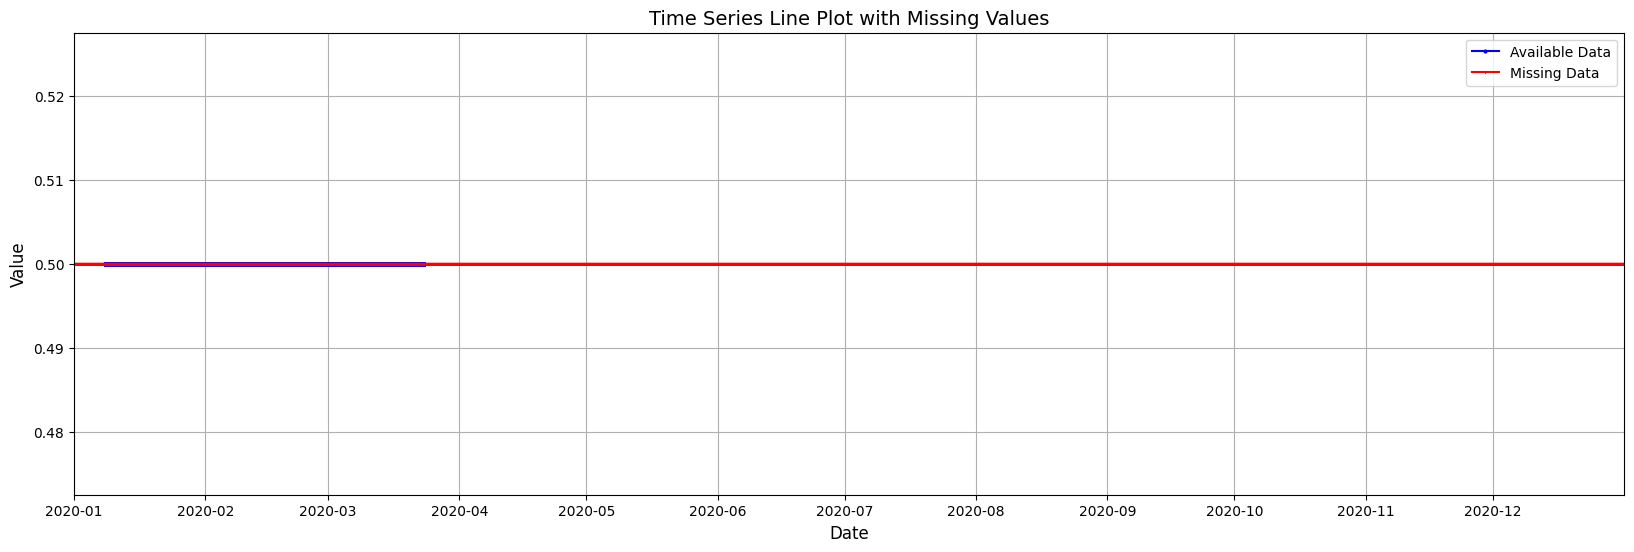

In [127]:
import matplotlib.pyplot as plt

# Example variable `i`
i = 0 + 0.5

# Sensor name
sensor_name = 'G72F040'

# Copy the sensor data
sensor_data = data[sensor_name].copy()

# Detect where the data is not NaN
not_nan = sensor_data.notna()

# Set all values to `i` (this seems unrelated to plotting missing values, so it's left in as is)
sensor_data.loc[:] = i

# Extract data with and without NaN values
has_data = sensor_data.loc[not_nan]  # Data points that are NOT NaN
has_no_data = sensor_data.loc[~not_nan]  # Data points that are NaN

# Plot the data
plt.figure(figsize=(20, 6))

# Plot the data where values are present (not NaN)
plt.plot(has_data.index, has_data, marker='o', markersize=2, color='blue', label='Available Data')

# Optionally, plot markers where data is missing (NaN)
if not has_no_data.empty:
    plt.plot(has_no_data.index, has_no_data, marker='x', markersize=1, color='red', label='Missing Data')

# Add title and labels
plt.title('Time Series Line Plot with Missing Values', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)

# Set the x-axis range
min_time, max_time = data.index.min(), data.index.max()
plt.xlim(min_time, max_time)

# Add legend
plt.legend()

# Display the plot
plt.grid(True)
plt.show()


### How is the distribution of values

- histogram
- boxplot